In [351]:
!pip install qulacs
!pip install qulacsvis
!pip install matplotlib
!pip install numpy
!pip install scipy
from utility import *

In [352]:
import matplotlib.pyplot as plt
import numpy as np
import time 
import random
from qulacs import Observable, QuantumState, QuantumCircuit
from qulacs.gate import DenseMatrix
from qulacs.circuit import QuantumCircuitOptimizer
from qulacsvis import circuit_drawer
from qulacs.gate import RandomUnitary
from qulacs.state import inner_product
from qulacs.gate import to_matrix_gate
import scipy.optimize

from qulacs.gate import Identity, X,Y,Z
from qulacs.gate import H,S,Sdag, sqrtX,sqrtXdag,sqrtY,sqrtYdag
from qulacs.gate import T,Tdag
from qulacs.gate import RX,RY,RZ
from qulacs.gate import CNOT, CZ, SWAP

# 受講証明用課題①

$$
\Lambda(U)_{1,2}=|0\rangle\langle0|\otimes I+|1\rangle\langle1|\otimes U = \left(I\otimes U\right)\left(I\otimes X^{\dagger}\right)CNOT_{1,2}
$$
より、任意の1qubitユニタリー演算子の分解方法とCNOT演算子の分解方法を組み合わせて制御U演算子を分解していく。

演習通りに行えば、パラメータがCNOT演算子の分解に3つと1qubitユニタリー演算子の分解に3つの合計6つで最適化を行う形になるが、より演算精度を高めるために、2qubit回転ゲートを途中に追加して7つのパラメータを最適化していく。

In [401]:
"""
    Create maximally entangled state of 2n qubit.
"""
def maximally_entangled_state(nqubits):
    state = QuantumState(2*nqubits)
    for i in range(nqubits):
        H(i).update_quantum_state(state)
        CNOT(i,i+nqubits).update_quantum_state(state)
    return state


In [402]:
"""
    Caluculate entanglement fidelity.
"""
def entanglement_fidelity(ansatz,nqubits):
    mes = maximally_entangled_state(int(nqubits/2))
    mes_copy = mes.copy()
    ansatz.update_quantum_state(mes)

    ent_fidelity = abs(inner_product(mes_copy,mes))**2
    return ent_fidelity


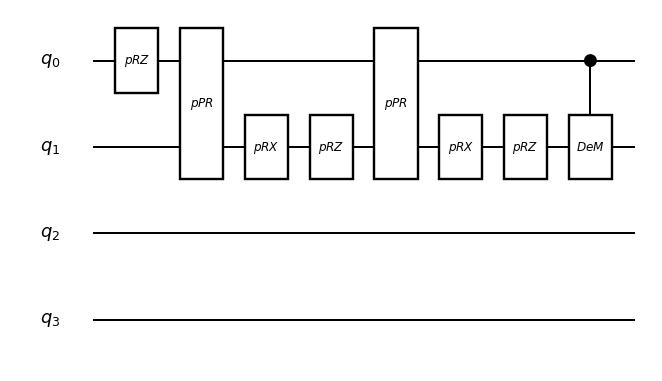

In [426]:
"""
    Crate an ansatz.
"""
nqubits = 4
ansatz = ParametricQuantumCircuit(nqubits)

ansatz.add_parametric_RZ_gate(0,0.0)
ansatz.add_parametric_multi_Pauli_rotation_gate([0,1],[3,1], 0.0)
ansatz.add_parametric_RX_gate(1,0.0)
ansatz.add_parametric_RZ_gate(1,0.0)
ansatz.add_parametric_multi_Pauli_rotation_gate([0,1],[3,1], 0.0)
ansatz.add_parametric_RX_gate(1,0.0)
ansatz.add_parametric_RZ_gate(1,0.0)

target_list = [1]
controlled_unitary = RandomUnitary(target_list)
control_index = 0
control_with_value = 1
controlled_unitary.add_control_qubit(control_index,control_with_value)
ansatz.add_gate(controlled_unitary)

circuit_drawer(ansatz, "mpl")

In [427]:
"""
    Make a cost function to minimize.
"""
def cost(parameters):
    num_paras = ansatz.get_parameter_count()
    
    for i in range(num_paras):
        ansatz.set_parameter(i,parameters[i])
    
    return 1 - entanglement_fidelity(ansatz,nqubits)

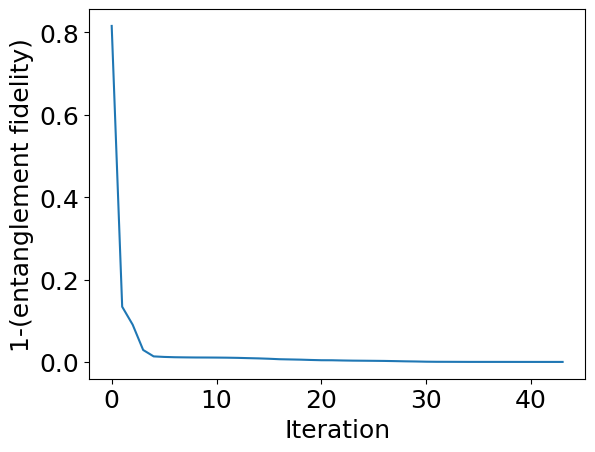

In [431]:
"""
    Excecute minimization.
"""
cost_history = []
np.random.seed(224)
init_theta_list = [random.random() for i in range(ansatz.get_parameter_count())]
cost_history.append(cost(init_theta_list))

method = "BFGS"
options = {"disp": True, "maxiter": 100, "gtol": 1e-6}

opt = scipy.optimize.minimize(cost, init_theta_list,
               method=method,
               callback=lambda x: cost_history.append(cost(x)))

plt.rcParams["font.size"] = 18
plt.plot(cost_history)
plt.xlabel("Iteration")
plt.ylabel("1-(entanglement fidelity)")
plt.show()

In [432]:
print("fidelity: ",opt.fun,"\nparameters: ",opt.x)

fidelity:  5.734037689109073e-10 
parameters:  [ 0.94814349  2.12290056 -2.12274104  2.80635517  0.6640923  -0.66391901
 -2.80636941]


0.9999999994892665


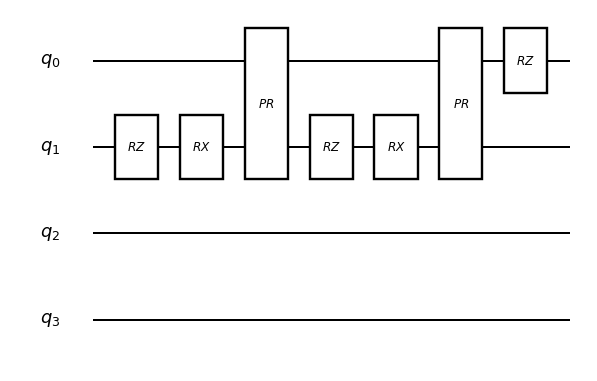

In [433]:
"""
    Check an accuracy of parameters we caluclated.
"""

nqubits = 4
state = QuantumState(nqubits)
state.set_Haar_random_state()
duplicate_of_state = state.copy()

controlled_unitary.update_quantum_state(state)

circuit = QuantumCircuit(nqubits)
circuit.add_RZ_gate(1,-1*opt.x[6])
circuit.add_RX_gate(1,-1*opt.x[5])
circuit.add_multi_Pauli_rotation_gate([0,1],[3,1],-1*opt.x[4])
circuit.add_RZ_gate(1,-1*opt.x[3])
circuit.add_RX_gate(1,-1*opt.x[2])
circuit.add_multi_Pauli_rotation_gate([0,1],[3,1],-1*opt.x[1])
circuit.add_RZ_gate(0,-1*opt.x[0])
circuit.update_quantum_state(duplicate_of_state)

print(abs(inner_product(state,duplicate_of_state))**2)
circuit_drawer(circuit,"mpl")